In [27]:
import timm
import torch
import torch.nn as nn
from torchsummary import summary

In [28]:
# net = timm.create_model("efficientvit_m5", pretrained=True)
net = timm.create_model("swin_large_patch4_window12_384", pretrained=True)
net

/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
model.safetensors: 100%|██████████| 801M/801M [00:03<00:00, 257MB/s] 


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate=none)
            (dr

In [30]:
import torch
import torch.nn as nn
from torchsummary import summary


class TestModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = timm.create_model("swin_large_patch4_window12_384", pretrained=True, num_classes=0)  # num_features = 512
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.mask_feature = nn.Sequential(
            nn.Linear(1536, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
        )
        
        self.feature_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
        )
        self.layer_64 = nn.Linear(128, 64)
        self.batchnorm_64 = nn.BatchNorm1d(64)
        self.layer_32 = nn.Linear(64, 32)
        self.batchnorm_32 = nn.BatchNorm1d(32)
        self.layer_16 = nn.Linear(32, 16)
        self.batchnorm_16 = nn.BatchNorm1d(16)
        
        self.gelu = nn.GELU()
        
        self.mask_classifier = nn.Linear(128, 3)
        self.gender_classifier = nn.Linear(16, 2)
        self.age_classifier = nn.Linear(16, 3)
        
        
    def forward(self, x):
        x = self.model(x)
        
        mask_feature = self.mask_feature(x)
        gender_feature = self.feature_layers(mask_feature)  # gender feature
        age_feature = self.feature_layers(gender_feature)  # age feature
        mask = self.mask_classifier(mask_feature)  # mask output = [batch, 3]
        
        # gender branch
        gender = self.layer_64(gender_feature)
        gender = self.batchnorm_64(gender)
        gender = self.layer_32(gender)
        gender = self.batchnorm_32(gender)
        gender = self.gelu(gender)
        gender = self.layer_16(gender)
        gender = self.batchnorm_16(gender)
        gender = self.gelu(gender)
        gender = self.gender_classifier(gender)  # gender output = [batch, 2]
        
        # age branch
        age = self.layer_64(age_feature)
        age = self.batchnorm_64(age)
        age = self.gelu(age)
        age = self.layer_32(age)
        age = self.batchnorm_32(age)
        age = self.gelu(age)
        age = self.layer_16(age)
        age = self.batchnorm_16(age)
        age = self.gelu(age)
        age = self.age_classifier(age)  # age output = [batch, 3]
        return mask, gender, age
        

model = TestModel(3).cuda()
summary(model, (3, 384, 384), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 192, 96, 96]           9,408
         LayerNorm-2           [1, 96, 96, 192]             384
        PatchEmbed-3           [1, 96, 96, 192]               0
          Identity-4           [1, 96, 96, 192]               0
         LayerNorm-5           [1, 96, 96, 192]             384
            Linear-6              [1, 144, 576]         111,168
           Softmax-7           [1, 6, 144, 144]               0
           Dropout-8           [1, 6, 144, 144]               0
            Linear-9              [1, 144, 192]          37,056
          Dropout-10              [1, 144, 192]               0
  WindowAttention-11              [1, 144, 192]               0
         Identity-12           [1, 96, 96, 192]               0
        LayerNorm-13             [1, 9216, 192]             384
           Linear-14             [1, 92

#### Focal loss weight

In [24]:
import torch


# class_1 = torch.zeros(100).long()
class_2 = torch.ones(500).long()
class_3 = torch.fill(torch.ones(1000), 2).long()
batch = torch.hstack([class_2, class_3]).view(-1)

each_class_count = batch.bincount()

if 0 in each_class_count:
    find_zero = each_class_count == 0
    each_class_count[find_zero] = 1

maximum = each_class_count.max()
each_class_count, maximum / each_class_count

tensor([ True, False, False])


(tensor([   1,  500, 1000]), tensor([1000.,    2.,    1.]))

In [16]:
import torch


class_1 = torch.zeros(100).long()
class_2 = torch.ones(500).long()
class_3 = torch.fill(torch.ones(1000), 2).long()
batch = torch.hstack([class_1, class_2, class_3]).view(-1)

each_class_count = batch.bincount()
minimum = each_class_count.min()
each_class_count, minimum / each_class_count

(tensor([   0,  500, 1000]), tensor([nan, 0., 0.]))

In [9]:
import torch
a = torch.tensor([0.7213])
b = torch.tensor([0.4887])
c = torch.tensor([0.7045])
softmax = torch.nn.functional.softmax(torch.tensor([a, b, c]), -1)
softmax, torch.tensor([a,b,c]) * softmax

(tensor([0.3603, 0.2855, 0.3543]), tensor([0.2599, 0.1395, 0.2496]))

In [53]:
import torch
a = torch.tensor([0.7213], requires_grad=True)
b = torch.tensor([0.4887], requires_grad=True)
c = torch.tensor([0.7045], requires_grad=True)
abc = torch.tensor([a,b,c], requires_grad=True)
maximum = abc.max().data
weights = (abc/maximum).data
abc = weights*abc
abc.sum().data

tensor(1.7405)

#### MixUp

In [ ]:
from torchvision import transforms
import numpy as np
def mixup(images, bboxes, areas, alpha=1.0):
    # Generate random indices to shuffle the images
    indices = torch.randperm(len(images))
    shuffled_images = images[indices]
    shuffled_bboxes = bboxes[indices]
    shuffled_areas = areas[indices]
    
    # Generate image weight (minimum 0.4 and maximum 0.6)
    lam = np.clip(np.random.beta(alpha, alpha), 0.4, 0.6)
    print(f'lambda: {lam}')
    
    # Weighted Mixup
    mixedup_images = lam*images + (1 - lam)*shuffled_images
    
    mixedup_bboxes, mixedup_areas = [], []
    for bbox, s_bbox, area, s_area in zip(bboxes, shuffled_bboxes, areas, shuffled_areas):
        mixedup_bboxes.append(bbox + s_bbox)
        mixedup_areas.append(area + s_area)
    
    return mixedup_images, mixedup_bboxes, mixedup_areas, indices.numpy()

# orig_img = Image.open(Path("data/train/images/000001_female_Asian_45") / "normal.jpg")
# data/train/images/000002_female_Asian_52/normal.jpg
aug_images, aug_bboxes, aug_areas, aug_indices = mixup(images, bboxes, areas)  # 이미지, bbox 좌표, 면적

In [16]:
import numpy as np
from torchvision import transforms
from PIL import Image
from pathlib import Path

class ConfigPath:
    data_dir = "./data/train"
    image_dir = f"{data_dir}/images"
    csv_path = f"{data_dir}/train.csv"

class MixUpDataset:
    def __init__(self, inputs, labels, mask, gender, age, alpha=1):
        self.inputs = inputs
        self.labels = labels
        self.mask = mask
        self.gender = gender
        self.age = age
        self.alpha = alpha

    @classmethod
    def mixup(self):
        if self.alpha > 0:
            lambda_ = np.random.beta(self.alpha, self.alpha)
        else:
            lambda_ = 1

        batch_size = self.inputs.size(0)
        indices = torch.randperm(batch_size)
        
        mixed_input = lambda_ * input + (1 - lambda_) * input[indices, :]
        labels_a, labels_b = self.labels, self.labels[indices]  # single-head
        mask_a, mask_b = self.mask, self.mask[indices]
        gender_a, gender_b = self.gender, self.gender[indices]
        age_a, age_b = self.age, self.age[indices]
        
        return lambda_, mixed_input, labels_a, labels_b, mask_a, mask_b, gender_a, gender_b, age_a, age_b

orig_img = Image.open(Path("data/train/images/000001_female_Asian_45") / "normal.jpg")
"data/train/images/000002_female_Asian_52/normal.jpg"

def MixUpLoss(criterion, pred, labels_a, labels_b, lambda_):
    return lambda_ * criterion(pred, labels_a) + (1 - lambda_) * criterion(pred, labels_b)

0.4672713422830137

#### AugMix

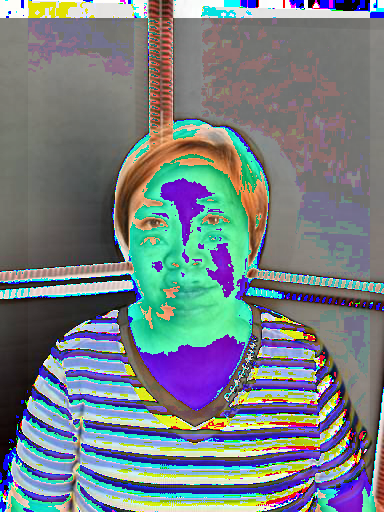

In [27]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
# from helpers import plot

agg = []
orig_img = Image.open(Path("data/train/images/000001_female_Asian_45") / "normal.jpg")
augmix = transforms.AugMix()
imgs = [augmix(orig_img) for _ in range(4)]

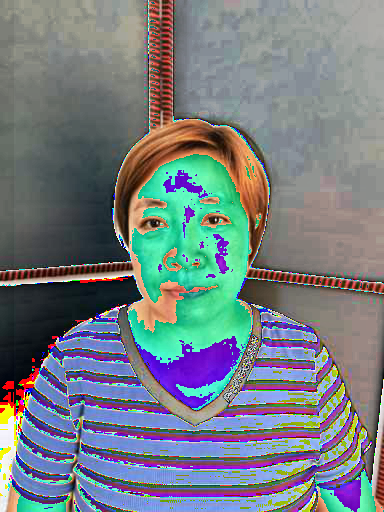

In [30]:
sample = transforms.Compose([transforms.AugMix(), transforms.ToTensor()])(imgs[3])
smaple_og = transforms.Compose([transforms.ToTensor()])(orig_img)
result = transforms.Compose([transforms.ToPILImage()])(sample + smaple_og)
result

In [26]:
import torch

# softmax 통과한 값
mask_1 = torch.tensor([0.05, 0.6, 0.35])
gender_1 = torch.tensor([0.9, 0.3])
age_1 = torch.tensor([0.21, 0.6, 0.19])

mask_2 = torch.tensor([0.45, 0.4, 0.15])
gender_2 = torch.tensor([0.5, 0.5])
age_2 = torch.tensor([0.71, 0.1, 0.19])

mask_3 = torch.tensor([0.1, 0.05, 0.85])
gender_3 = torch.tensor([0.75, 0.25])
age_3 = torch.tensor([0.41, 0.28, 0.31])

def soft_voting(mask, gender, age):
    classes = []
    for m in mask:
        for g in gender:
            for a in age:
                classes.append(m*6 + g*3 + a)
    return torch.tensor(classes)

model_1 = soft_voting(mask_1, gender_1, age_1)
model_2 = soft_voting(mask_2, gender_2, age_2)
model_3 = soft_voting(mask_3, gender_3, age_3)

# print(model_1, model_2, model_3, sep="\n")
total = torch.vstack([model_1, model_2, model_3])
# torch.mean(total, 0)
total, total.shape, model_1[0], model_2[0], torch.mean(total, 0), torch.argmax(torch.mean(total, 0), -1)

(tensor([[3.2100, 3.6000, 3.1900, 1.4100, 1.8000, 1.3900, 6.5100, 6.9000, 6.4900,
          4.7100, 5.1000, 4.6900, 5.0100, 5.4000, 4.9900, 3.2100, 3.6000, 3.1900],
         [4.9100, 4.3000, 4.3900, 4.9100, 4.3000, 4.3900, 4.6100, 4.0000, 4.0900,
          4.6100, 4.0000, 4.0900, 3.1100, 2.5000, 2.5900, 3.1100, 2.5000, 2.5900],
         [3.2600, 3.1300, 3.1600, 1.7600, 1.6300, 1.6600, 2.9600, 2.8300, 2.8600,
          1.4600, 1.3300, 1.3600, 7.7600, 7.6300, 7.6600, 6.2600, 6.1300, 6.1600]]),
 torch.Size([3, 18]),
 tensor(3.2100),
 tensor(4.9100),
 tensor([3.7933, 3.6767, 3.5800, 2.6933, 2.5767, 2.4800, 4.6933, 4.5767, 4.4800,
         3.5933, 3.4767, 3.3800, 5.2933, 5.1767, 5.0800, 4.1933, 4.0767, 3.9800]),
 tensor(12))